# Writing a VCell simulation dataset to Zarr

In [1]:
import os
import tarfile
from pathlib import Path
import matplotlib.pyplot as plt
import zarr
from vcelldata.mesh import CartesianMesh
from vcelldata.simdata_models import PdeDataSet, DataFunctions
from vcelldata.zarr_writer import write_zarr

## extract the vcell simulation dataset from the tarball (compressed to save space)

In [2]:
test_data_dir = Path(os.getcwd()) / "test_data"

def extract_simdata() -> None:
    if (test_data_dir / "SimID_946368938_0_.log").exists():
        return
    with tarfile.open(test_data_dir / "SimID_946368938_simdata.tgz", 'r:gz') as tar:
        tar.extractall(path=test_data_dir)
        
extract_simdata()

## read vcell simulation results metadata
* `PdeDataSet` contains the metadata for the tabular simulation results (e.g. state variables, shape, time points)
* `DataFunctions` contains the function definitions (name, expression, type, domain)
![vcell simulation results](./example_vcell_ui.png)

In [3]:
sim_id = 946368938
job_id = 0
pde_dataset = PdeDataSet(base_dir=test_data_dir, log_filename=f"SimID_{sim_id}_{job_id}_.log")
pde_dataset.read()
data_functions = DataFunctions(function_file=test_data_dir / f"SimID_{sim_id}_{job_id}_.functions")
data_functions.read()
mesh = CartesianMesh(mesh_file=test_data_dir / f"SimID_{sim_id}_{job_id}_.mesh")
mesh.read()

## write the vcell simulation dataset to zarr including:
* metadata
* numerical datasets from stored data and evaluated functions
* ... masks for domains coming soon (e.g. cell, extracellular, etc.)

In [4]:
write_zarr(pde_dataset=pde_dataset, data_functions=data_functions, mesh=mesh, zarr_dir=test_data_dir / "zarr")

## Open and display slices from the zarr dataset as an image
* no masking for domains
* different colormap and scaling

In [5]:
# Open the Zarr dataset
dataset = zarr.open(test_data_dir / "zarr", mode='r')
metadata = dataset.attrs.asdict()['metadata']
display(f"shape = {dataset.shape}")
display(metadata)

'shape = (5, 6, 25, 71, 71)'

{'axes': [{'name': 't', 'type': 'time', 'unit': 'second'},
  {'name': 'c', 'type': 'channel', 'unit': None},
  {'name': 'z', 'type': 'space', 'unit': 'micrometer'},
  {'name': 'y', 'type': 'space', 'unit': 'micrometer'},
  {'name': 'x', 'type': 'space', 'unit': 'micrometer'}],
 'channels': [{'domain_name': 'all',
   'index': 0,
   'label': 'region_mask',
   'max_value': 5,
   'min_value': 0},
  {'domain_name': 'cytosol',
   'index': 1,
   'label': 'C_cyt',
   'max_values': [0.0,
    1.6578610937269188e-05,
    3.688810690038264e-05,
    5.838639163921412e-05,
    7.973304853048764e-05],
   'mean_values': [0.0,
    1.6684491059409372e-07,
    5.37820903345834e-07,
    1.0131317372551273e-06,
    1.5374842617646347e-06],
   'min_values': [0.0, 0.0, 0.0, 0.0, 0.0]},
  {'domain_name': 'cytosol',
   'index': 2,
   'label': 'Ran_cyt',
   'max_values': [0.0,
    1.6578610937269188e-05,
    3.688810690038264e-05,
    5.838639163921412e-05,
    7.973304853048764e-05],
   'mean_values': [0.0,
  

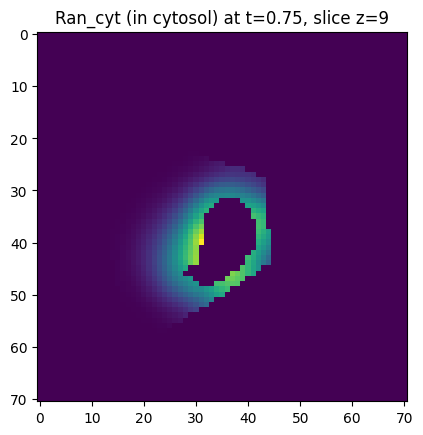

In [6]:

# Get a slice of the dataset, shape is (time, channel, z, y, x)
channel_index = 2
z_index = 9
time_index = 3
slice = dataset[time_index, channel_index, z_index, :, :]
channel_label = metadata['channels'][channel_index]['label']
channel_domain = metadata['channels'][channel_index]['domain_name']
t = metadata['times'][time_index]
title = f"{channel_label} (in {channel_domain}) at t={t}, slice z={z_index}"

# Display the slice as an image
plt.imshow(slice)
plt.title(title)
plt.show()

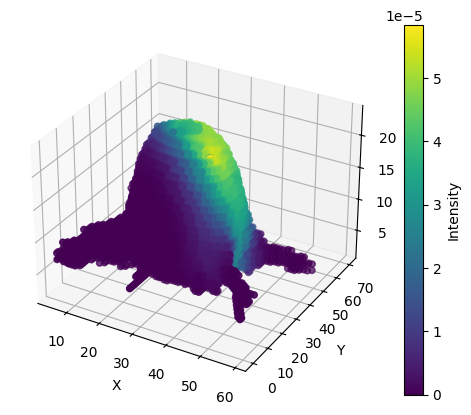

In [7]:
import numpy as np

# Select a 3D volume for a single time point and channel, shape is (z, y, x)
channel_index = 2
time_index = 3
channel_domain = metadata['channels'][channel_index]['domain_name']
volume = dataset[time_index, channel_index, :, :, :]

# Create a figure for 3D plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a mask to display the volume (use 'region_mask' channel)
mask = np.copy(dataset[3, 0, :, :, :])
z, y, x = np.where(mask == 1)

# Get the intensity values for these points
intensities = volume[z, y, x]

# Create a 3D scatter plot
scatter = ax.scatter(x, y, z, c=intensities, cmap='viridis')

# Add a color bar to represent intensities
fig.colorbar(scatter, ax=ax, label='Intensity')

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

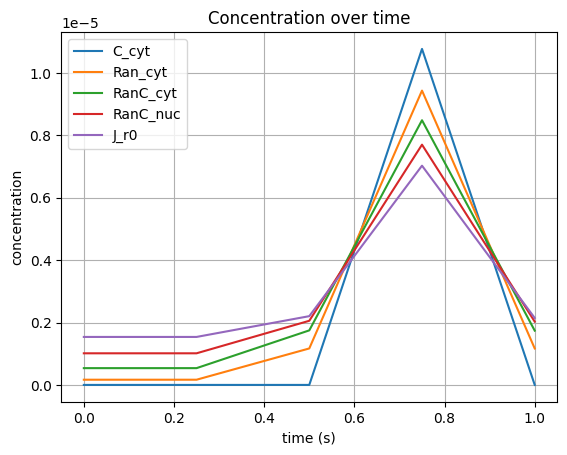

In [8]:
t = metadata['times']
y = [c['mean_values'] for c in metadata['channels'] if c['index'] > 0]
y_labels = [c['label'] for c in metadata['channels'] if c['index'] > 0]

fig, ax = plt.subplots()
ax.plot(t, y)
ax.set(xlabel='time (s)', ylabel='concentration',
       title='Concentration over time')
ax.legend(y_labels)
ax.grid()
